# TOV Emulator to train a NN to predict mass and radius of a Neutron Strar from a PP EOS

### <div style= 'color: goldenrod'> Import all the required modules

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numba import jit

%matplotlib widget

### <div style= 'color: goldenrod'> Global constants and unit conversion factors

In [2]:
msun=147660                 # Solar mass in cm given by the formula G*M_sun/c^2

c=2.9979e10                 # speed of light in cm/s (CGS)
G=6.67408e-8                # gravitational constant in cm^3/gm/s^2 (CGS)

dkm = 1.3234e-06            # conversion of MeV/fm^3 to km^-2
dcgs = 1.78e12              # factor to convert from MeV/fm^3 to gm/cm^3
conv = 8.2601e-40           # dyn/cm^2 to km^-2
cgs1=1.7827e+12             # MeV/fm3 to gms/cm3
cgs2=1.6022e+33             # MeV/fm3 to dyne/cm2

### <div style= 'color: goldenrod'> Piecewise-polytrope low-density (crust) parameters

In [3]:
# Polytropic exponents
GammaL_1 = 1.35692
GammaL_2 = 0.62223
GammaL_3 = 1.28733
GammaL_4 = 1.58425

# Polytropic constants
KL_1 = 3.99874e-8 # * pow(Msun/Length**3, GammaL_1-1)
KL_2 = 5.32697e+1 # * pow(Msun/Length**3, GammaL_2-1)
KL_3 = 1.06186e-6 # * pow(Msun/Length**3, GammaL_3-1)
KL_4 = 6.80110e-9 # * pow(Msun/Length**3, GammaL_4-1)
# notice a missing c^2 in Ki values in Table II of Read et al. 2009

# Densities at the boundaries of the piecewise polytropes
rhoL_1 = 2.62789e12
rhoL_2 = 3.78358e11
rhoL_3 = 2.44034e7
rhoL_4 = 0.0

# Pressures at the boundaries of the piecewise polytropes
pL_1 = KL_1*rhoL_1**GammaL_1
pL_2 = KL_2*rhoL_2**GammaL_2
pL_3 = KL_3*rhoL_3**GammaL_3
pL_4 = 0.0

# The exact numbers are taken from a particular crust model/table.

### <div style= 'color: goldenrod'> Few more calculations

In [4]:
# Compute the offsets specific internal energy (epsL_i) and alphaL_i at the boundaries
# The general form used: ε(ρ)=(1+α)ρ+K/(Γ−1)ρ^Γ. Solving for alpha ensures matching across boundaries.
# Energy density needs an additive offset to enforce continuity.

epsL_4 = 0.0
alphaL_4 = 0.0
epsL_3 = (1+alphaL_4)*rhoL_3 + KL_4/(GammaL_4 - 1.)*pow(rhoL_3, GammaL_4)
alphaL_3 = epsL_3/rhoL_3 - 1.0 - KL_3/(GammaL_3 - 1.)*pow(rhoL_3, GammaL_3 -1.0)
epsL_2 = (1+alphaL_3)*rhoL_2 + KL_3/(GammaL_3 - 1.)*pow(rhoL_2, GammaL_3)
alphaL_2 = epsL_2/rhoL_2 - 1.0 - KL_2/(GammaL_2 - 1.)*pow(rhoL_2, GammaL_2 -1.0)
epsL_1 = (1+alphaL_2)*rhoL_1 + KL_2/(GammaL_2 - 1.)*pow(rhoL_1, GammaL_2)
alphaL_1 = epsL_1/rhoL_1 - 1.0 - KL_1/(GammaL_1 - 1.)*pow(rhoL_1, GammaL_1 -1.0)

# Density thresholds for high-density polytropes
rho1 = pow(10,14.7) # Break Density
rho2 = pow(10,15.0) # Break Density

# GR conversion prefactors to go from cgs pressure/energy-density units into geometric units (where G=c=1)
t_p=G/c**4
t_rho=G/c**2

### <div style= 'color: goldenrod'> Forward EOS: ρ↦(p,ε)

In [5]:
def p_eps_of_rho(rho,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1)) 
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    if rho<rhoL_3:
        p = KL_4*pow(rho,GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif rhoL_3<= rho <rhoL_2: 
        p = KL_3*pow(rho,GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif rhoL_2<= rho <rhoL_1:
        p = KL_2*pow(rho,GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif rhoL_1<= rho <rho0:
        p = KL_1*pow(rho,GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif rho0<= rho <rho1:
        p = K1*pow(rho,Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif rho1<= rho <rho2:
        p = K2*pow(rho,Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        p = K3*pow(rho,Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return p*c**2, eps*c**2

### <div style= 'color: goldenrod'> Inverse EOS: p↦ε

In [6]:
@jit(nopython=True)
def eps(p,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    p*=1/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1))
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    p0 = K1*pow(rho0,Gamma1)
    p2 = K3*pow(rho2,Gamma3)
    if  p<pL_3:
        rho = pow(p/KL_4,1/GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif pL_3<= p <pL_2:
        rho = pow(p/KL_3,1/GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif pL_2<= p <pL_1:
        rho = pow(p/KL_2,1/GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif  pL_1<p <p0:
        rho = pow(p/KL_1,1/GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif p0<= p <p1:
        rho = pow(p/K1,1/Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif p1<= p <p2:
        rho = pow(p/K2,1/Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        rho = pow(p/K3,1/Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return eps*c**2

### <div style= 'color: yellow'> The TOV Integrator

In [7]:
def TOV(logrho_c,theta):
    seq=[]
    logp,Gamma1,Gamma2,Gamma3 = theta[0],theta[1],theta[2],theta[3]
    dr=100
    rho_c = pow(10,logrho_c)
    m=0.0
    r=0.1
    p,e = p_eps_of_rho(rho_c,theta[0],theta[1],theta[2],theta[3])
    p*=t_p
    e*=t_p
       
    while p >= 0:
        p += -(e+p)*(m+4.0*np.pi*(r**3.0)*p)*dr/(r*(r-2.0*m))
        if p <= 0:
            break               
        m += 4.0*np.pi*(r**2.0)*e*dr
        r += dr
        e = eps(p/t_p,theta[0],theta[1],theta[2],theta[3])*t_p
            
    return  m/msun,r/1e5

### <div style= 'color: yellow'> Produce a mass-radius curve for a single EOS

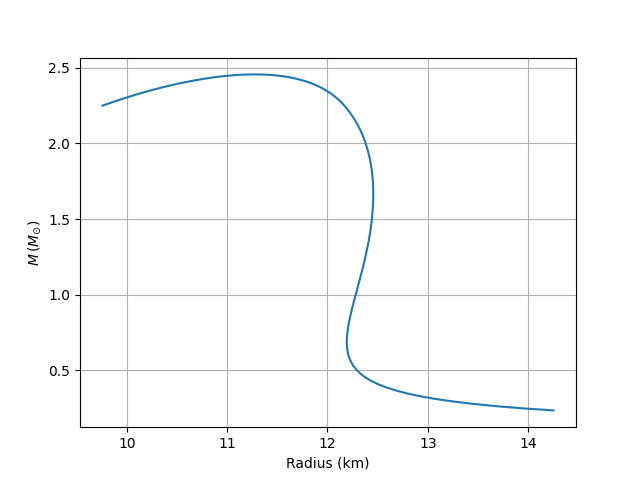

In [8]:
logrho_c_array=np.linspace(14.5,15.4,100)
theta=[34.495, 3.446, 3.572, 2.887] # MPA1

seq=[]
for logrho_c in logrho_c_array:
    m,r=TOV(logrho_c,theta)
    seq.append((m,r))
    
seq=np.vstack(seq)

plt.plot(seq[:,1],seq[:,0])
plt.grid()
plt.xlabel('Radius (km)')
plt.ylabel(r'$M \, (M_{\odot})$')
plt.show()

### <div style= 'color: slateblue'>Create dataset of EOS parameter samples & run TOV to create targets

In [9]:
# Number of EOS samples
num_samples = 10000  

EOS_params = np.random.uniform(low=[1.4, 1.4, 1.4], 
                                   high=[5., 5., 5.], 
                                   size=(num_samples, 3))

# Sample central mass density (in dyn/cm²)
logrho_c_samples = np.random.uniform(low=14.5, high=15.4, size=(num_samples, 1))

# Sample log-pressure at the first break (in dyn/cm²)
logp_samples = np.random.uniform(low=33.5, high=34.8, size=(num_samples, 1))

# Placeholder for Mass, Radius
MR_data = []

# Generate dataset
for i in range(num_samples):
    logrho_c = logrho_c_samples[i, 0]
    logp = logp_samples[i, 0]
    params = EOS_params[i]
    M,R = TOV(logrho_c,[logp, params[0], params[1], params[2]])
    MR_data.append([M,R])

# Convert to NumPy array
EOS_data = np.hstack([logrho_c_samples, logp_samples, EOS_params, np.array(MR_data)])

# Save dataset
np.save("EOS_dataset_4.npy", EOS_data)

### <div style= 'color: yellow'> PyTorch ML pipeline — load & prepare data

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = np.load("EOS_dataset_4.npy")
print(data[1:5],"\n...\n", data[9995:10000])


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load dataset
data = np.load("EOS_dataset_4.npy")

# Convert to pytorch tensors
X = torch.tensor(data[ : , :5], dtype=torch.float32)  # log_rho_c, logp, Gamma1, Gamma2, Gamma3
y = torch.tensor(data[ : , 5:7], dtype=torch.float32)  # Mass, Radius

# Shuffling the dataset
indices = torch.randperm(len(X))
train_size = int(0.8 * len(X))
train_idx = indices[:train_size]
val_idx = indices[train_size:]

# Split into training and validation sets
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# # Convert R -> log(R)
# y_train_log = y_train.clone()
# y_train_log[:,1] = torch.log(y_train[:,1])  # only log(Radius) for training
# y_val_log = y_val.clone()
# y_val_log[:,1] = torch.log(y_val[:,1]) # only log(Radius) for validation

# Compute mean and std only on the training dataset
X_mean, X_std = X_train.mean(dim=0, keepdim=True), X_train.std(dim=0, keepdim=True)
# y_mean, y_std = y_train_log.mean(dim=0), y_train_log.std(dim=0)

mass_mean, mass_std = y_train[:,0].mean(), y_train[:,0].std() # mass
logR_mean, logR_std = torch.log(y_train[:,1]).mean(), torch.log(y_train[:,1]).std() # log radius


# Normalize inputs of the training dataset
X_train_norm = (X_train - X_mean) / X_std
# y_train_norm = (y_train_log - y_mean) / y_std

# Normalize targets (mass and radius) seperately of the training dataset
y_train_norm = torch.zeros_like(y_train)
y_train_norm[:,0] = (y_train[:,0] - mass_mean) / mass_std
y_train_norm[:,1] = (torch.log(y_train[:,1]) - logR_mean) / logR_std

# Normalize inputs of the validation dataset
X_val_norm   = (X_val - X_mean) / X_std
# y_val_norm   = (y_val_log - y_mean) / y_std

# Normalize targets (mass and radius) seperately of the validation dataset
y_val_norm = torch.zeros_like(y_val)
y_val_norm[:,0] = (y_val[:,0] - mass_mean) / mass_std
y_val_norm[:,1] = (torch.log(y_val[:,1]) - logR_mean) / logR_std


# Reshape the tensors for dataloader
X_train_norm, y_train_norm = X_train_norm.view(-1, 5), y_train_norm.view(-1, 2)
X_val_norm, y_val_norm = X_val_norm.view(-1, 5), y_val_norm.view(-1, 2)

[[14.71194939 34.1364079   2.49689526  3.61322691  4.24111012  0.33240499
  11.966001  ]
 [14.68228854 35.26343583  3.23587818  3.22457436  3.07609918  3.11879886
  17.776001  ]
 [15.36432446 34.89765714  2.85829324  2.74663731  3.06018309  2.35507262
  10.673001  ]
 [14.81641007 35.40479551  4.11419866  4.45458818  4.57510081  3.87526046
  16.157001  ]] 
...
 [[14.68748119 34.16793855  2.33320906  2.11774701  3.16095077  0.34476027
  12.615001  ]
 [15.18175038 34.33292837  3.33186425  2.07775146  3.56000802  1.51008723
   9.942001  ]
 [15.03553849 35.47222309  2.77348823  4.01031528  1.96446811  3.44526254
  15.064001  ]
 [14.98995816 34.46134122  4.84785099  3.05161783  2.2796501   1.78020191
  11.746001  ]
 [14.68693626 34.56135055  2.81224013  2.07545527  2.89439304  0.91305682
  13.442001  ]]
Using device: cuda


In [11]:
print(y_train[:5])
print(y_train_norm[:10])

tensor([[ 2.2333, 15.2230],
        [ 1.8948,  8.7530],
        [ 2.1418, 20.0570],
        [ 3.4386, 16.9920],
        [ 0.7355, 12.0840]])
tensor([[ 0.1303,  0.1973],
        [-0.1850, -1.2698],
        [ 0.0451,  0.9284],
        [ 1.2528,  0.4888],
        [-1.2646, -0.4148],
        [ 0.5619, -0.0669],
        [ 0.1981, -0.9602],
        [-0.0037, -1.1383],
        [ 0.2486, -0.4678],
        [ 1.1103,  1.1906]])


### <div style= 'color: yellow'> NN Definition

In [ ]:
import torch
import torch.nn as nn

# Define Neural Network
class PP_NN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=2):
        super(PP_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.001) # Dropout layer for regularization
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

In [39]:
PP_NN()

PP_NN(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.001, inplace=False)
)

### <div style= 'color: slateblue'> Train the model (batch wise gradient descent) and plot losses

Epoch [100/3000] | Train Loss: 0.020157 | Val Loss: 0.020902
Epoch [200/3000] | Train Loss: 0.009062 | Val Loss: 0.009652
Epoch [300/3000] | Train Loss: 0.005145 | Val Loss: 0.006165
Epoch [400/3000] | Train Loss: 0.003295 | Val Loss: 0.004683
Epoch [500/3000] | Train Loss: 0.003033 | Val Loss: 0.004430
Epoch [600/3000] | Train Loss: 0.002014 | Val Loss: 0.003756
Epoch [700/3000] | Train Loss: 0.002250 | Val Loss: 0.003494
Epoch [800/3000] | Train Loss: 0.001501 | Val Loss: 0.003312
Epoch [900/3000] | Train Loss: 0.001705 | Val Loss: 0.003295
Epoch [1000/3000] | Train Loss: 0.001551 | Val Loss: 0.003223
Epoch [1100/3000] | Train Loss: 0.001476 | Val Loss: 0.003063
Epoch [1200/3000] | Train Loss: 0.001314 | Val Loss: 0.003044
Epoch [1300/3000] | Train Loss: 0.001790 | Val Loss: 0.003319
Epoch [1400/3000] | Train Loss: 0.001185 | Val Loss: 0.003169
Epoch [1500/3000] | Train Loss: 0.001085 | Val Loss: 0.002911
Epoch [1600/3000] | Train Loss: 0.000981 | Val Loss: 0.002790
Epoch [1700/3000]

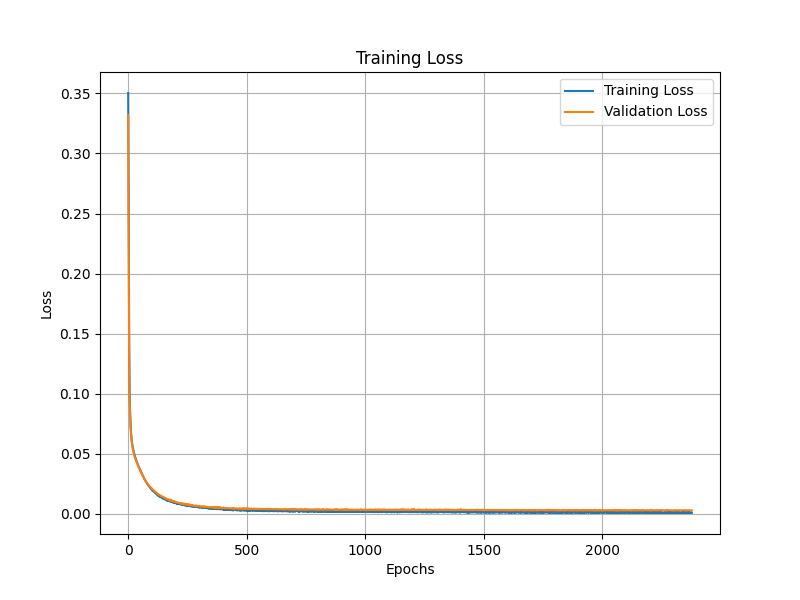

In [45]:
# Initialize the model
model = PP_NN().to(device)

# Loss and Optimizer
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200)

# Mini-batch setup
batch_size = 256   
train_dataset = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_norm, y_val_norm)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
epochs = 3000  # fewer epochs because mini-batch converges faster
training_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 500  # Number of epochs to wait for improvement before stopping
patience_counter = 0

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    training_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            loss = criterion(val_outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model weights
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

# Restore best model
model.load_state_dict(best_model_state)
print(f"Training finished. Best validation loss: {best_val_loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.legend()
plt.show()

# Save trained model
torch.save(model.state_dict(), "PP_TOV_Emulator_4_model7.pth")


In [46]:
# Load the trained model for evaluation

# Instantiate the model class
model = PP_NN()
# Load the saved state dict
model.load_state_dict(torch.load(f"/home/kay/ML-for-Neutron-Stars/2_PP_emulator/Extended versions/Emulator_4/PP_TOV_Emulator_4_model7.pth"))

model.eval()  # Set the model to evaluation mode

PP_NN(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.001, inplace=False)
)

### <div style= 'color: yellow'> Evaluate / compare TOV vs NN predictions for a full grid of logp, Gamma1, Gamma2, Gamma3

In [47]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# # Prepare ranges for Gamma1, Gamma2 and Gamma3
# Gamma1_values = [2., 3., 4.]  
# Gamma2_values = [2., 3., 4.]  
# Gamma3_values = [2., 3., 4.]  

# # Prepare the array for logp values
# logp_values = np.linspace(33.5, 34.8, 10)

# # Prepare the array for logrho_c values
# logrho_c_array = np.linspace(14.5, 15.4, 100)

# # Initialize lists to store results
# predicted_mass = []
# predicted_radius = []
# original_mass = []
# original_radius = []

# results = {}

# # Iterate over all logp and Gamma1 values
# for Gamma1 in Gamma1_values:
#     for Gamma2 in Gamma2_values:
#         for Gamma3 in Gamma3_values:
#             for logp in logp_values:
#                 # Store results for this logp and Gamma1 combination
#                 predicted_mass_single = []
#                 predicted_radius_single = []
#                 original_mass_single = []
#                 original_radius_single = []

#                 for logrho_c in logrho_c_array:
#                     # Prepare input tensor for prediction
#                     input_tensor = torch.tensor([[logrho_c, logp, Gamma1, Gamma2, Gamma3]], dtype=torch.float32)
                    
#                     # Normalize the input data using the training mean and std
#                     input_norm = (input_tensor - X_mean) / X_std
                    
#                     # Make predictions with the trained model
#                     with torch.no_grad():
#                         prediction = model(input_norm)
                    
#                     # Convert the prediction tensor to NumPy and denormalize the predicted mass and radius
#                     prediction_np = prediction.detach().numpy()[0]  # Convert to NumPy and get the first element
                    
#                     # Denormalize the predicted mass and radius
#                     mass_pred, radius_pred = prediction_np * y_std.numpy() + y_mean.numpy()
                    
#                     # Calculate original mass and radius using TOV
#                     M_orig, R_orig = TOV(logrho_c, [logp, Gamma1, Gamma2, Gamma3])
                    
#                     # Store the results
#                     predicted_mass_single.append(mass_pred)
#                     predicted_radius_single.append(radius_pred)
#                     original_mass_single.append(M_orig)
#                     original_radius_single.append(R_orig)

#                 # Store the full curve under a key tuple
#                 key = (Gamma1, Gamma2, Gamma3, logp)
#                 results[key] = {
#                     "orig_mass": original_mass_single,
#                     "orig_radius": original_radius_single,
#                     "pred_mass": predicted_mass_single,
#                     "pred_radius": predicted_radius_single,
#                 }

# # Plotting Mass vs Radius for each kappa, gamma combination
# plt.figure(figsize=(11, 8))

# # Fix all Gammas for visualization
# Gamma1_fixed = Gamma1_values[0]
# Gamma2_fixed = Gamma2_values[0]
# Gamma3_fixed = Gamma3_values[0]

# # Filter keys that match these fixed Gammas
# filtered_keys = [(g1, g2, g3, logp) for (g1, g2, g3, logp) in results.keys()
#                  if g1 == Gamma1_fixed and g2 == Gamma2_fixed and g3 == Gamma3_fixed]

# # Sort by logp
# filtered_keys.sort(key=lambda x: x[3])

# # Take every 2nd logp curve for clarity
# sampled_keys = filtered_keys[::10]

# colors = plt.cm.viridis(np.linspace(0, 1, len(sampled_keys)))
# plt.figure(figsize=(10, 8))

# for color, key in zip(colors, sampled_keys):
#     _, _, _, logp = key
#     data = results[key]
#     plt.plot(data["orig_radius"], data["orig_mass"], '-', color=color, label=f"TOV logp={logp:.2f}")
#     plt.plot(data["pred_radius"], data["pred_mass"], '--', color=color)

# plt.xlabel("Radius (km)")
# plt.ylabel("Mass (M⊙)")
# plt.xlim(6, 20)
# plt.ylim(0, 3)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0)
# plt.title(f"Mass–Radius Curves for Fixed Γ₁={Gamma1_fixed}, Γ₂={Gamma2_fixed}, Γ₃={Gamma3_fixed}")
# plt.grid()
# plt.tight_layout()
# plt.show()

### <div style= 'color: yellow'> Evaluate / compare TOV vs NN predictions for a random subsample of logp, Gamma1, Gamma2, Gamma3

/tmp/ipykernel_3241586/2902164556.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  radius_pred = np.exp(pred_denormalize[1] * logR_std + logR_mean)


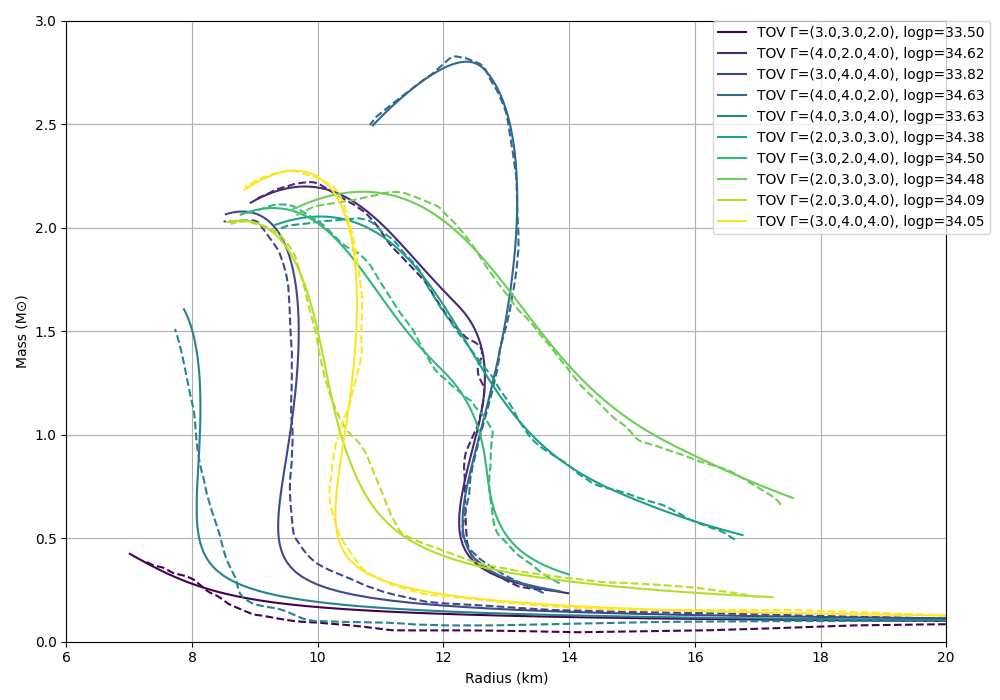

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import itertools
import random

Gamma1_values = [2., 3., 4.]
Gamma2_values = [2., 3., 4.]
Gamma3_values = [2., 3., 4.]
logp_values = np.linspace(33.5, 34.8, 100)
logrho_c_array = np.linspace(14.5, 15.4, 100)

# Randomly select e.g. 3 combinations of (Γ1,Γ2,Γ3,logp)
param_combinations = list(itertools.product(Gamma1_values, Gamma2_values, Gamma3_values, logp_values))
sampled_combinations = random.sample(param_combinations, 10)  # 10 random combos

plt.figure(figsize=(10, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(sampled_combinations)))

predicted_mass = []
predicted_radius = []
original_mass = []
original_radius = []

for color, (Gamma1, Gamma2, Gamma3, logp) in zip(colors, sampled_combinations):
    predicted_mass_single = []
    predicted_radius_single = []
    original_mass_single = []
    original_radius_single = []

    for logrho_c in logrho_c_array:
        # Prepare input and normalize
        input_tensor = torch.tensor([[logrho_c, logp, Gamma1, Gamma2, Gamma3]], dtype=torch.float32)
        input_norm = (input_tensor - X_mean) / X_std

        # Predict
        with torch.no_grad():
            prediction = model(input_norm)

        # Denormalize predictions
        pred_denormalize = (prediction.numpy()[0])
        mass_pred = pred_denormalize[0].item()* mass_std + mass_mean
        
        # Since model output for R was log(R), exponentiate to get R
        radius_pred = np.exp(pred_denormalize[1] * logR_std + logR_mean)


        M_orig, R_orig = TOV(logrho_c, [logp, Gamma1, Gamma2, Gamma3])

        predicted_mass_single.append(mass_pred)
        predicted_radius_single.append(radius_pred)
        original_mass_single.append(M_orig)
        original_radius_single.append(R_orig)

    # store for metrics later
    predicted_mass.append(predicted_mass_single)    
    predicted_radius.append(predicted_radius_single)
    original_mass.append(original_mass_single)
    original_radius.append(original_radius_single)

    plt.plot(original_radius_single, original_mass_single, '-', color=color, label=f"TOV Γ=({Gamma1},{Gamma2},{Gamma3}), logp={logp:.2f}")
    plt.plot(predicted_radius_single, predicted_mass_single, '--', color=color)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M⊙)")
plt.xlim(6, 20)
plt.ylim(0, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0)
plt.grid()
plt.tight_layout()
plt.show()


### <div style= 'color: orange'> Model Metrics

In [49]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

orig_mass_all = np.concatenate(original_mass)
pred_mass_all = np.concatenate(predicted_mass)
orig_radius_all = np.concatenate(original_radius)
pred_radius_all = np.concatenate(predicted_radius)

mae_mass = mean_absolute_error(orig_mass_all, pred_mass_all)
rmse_mass = np.sqrt(mean_squared_error(orig_mass_all, pred_mass_all))
r2_mass = r2_score(orig_mass_all, pred_mass_all)

mae_radius = mean_absolute_error(orig_radius_all, pred_radius_all)
rmse_radius = np.sqrt(mean_squared_error(orig_radius_all, pred_radius_all))
r2_radius = r2_score(orig_radius_all, pred_radius_all)

norm_rmse = np.mean([
    rmse_mass / np.mean(orig_mass_all),
    rmse_radius / np.mean(orig_radius_all)
])

print(f"Mass:    MAE={mae_mass:.4f}, RMSE={rmse_mass:.4f}, R²={r2_mass:.4f}")
print(f"Radius:  MAE={mae_radius:.4f}, RMSE={rmse_radius:.4f}, R²={r2_radius:.4f}")
print(f"Combined normalized RMSE = {norm_rmse:.4f}")


Mass:    MAE=0.0291, RMSE=0.0521, R²=0.9959
Radius:  MAE=91.6243, RMSE=951.5590, R²=-7.9084
Combined normalized RMSE = 8.0923
